# **Iterative Modelling (Initial Model V.1)**

In [1]:
import math
import pandas as pd
from ortools.sat.python import cp_model
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D
from shapely.geometry import LineString
import os

In [5]:
def solve_model_v1(df, budget=1000, time_limit_sec=600):
    print(f"\nMODEL V1")
    print(f"Budget: {budget} kEUR | Max Time: {time_limit_sec}s")

    model = cp_model.CpModel()

    # --- 1. SETS & INDICES ---
    I = df['grid_id'].tolist()
    id_to_idx = {val: i for i, val in enumerate(I)}
    S = ['atelerix', 'martes', 'eliomys', 'oryctolagus']
    
    # --- 2. PARAMETERS ---
    SCALE = 100 
    budget_int = int(budget * SCALE)
    
    # Load Dicts
    A = {row['grid_id']: row['cell_area_km2'] for _, row in df.iterrows()}
    C_adapt = {}
    Q = {}
    delta_Q = {}
    
    for s in S:
        C_adapt[s] = {r['grid_id']: int(r[f'cost_adaptation_{s}'] * SCALE) for _, r in df.iterrows()}
        Q[s] = df.set_index('grid_id')[f'suitability_{s}'].to_dict()
        delta_Q[s] = {i: max(0, 3.0 - Q[s][i]) for i in I}

    COL_HAS = {'atelerix': 'has_atelerix_algirus', 'martes': 'has_martes_martes',
               'eliomys': 'has_eliomys_quercinus', 'oryctolagus': 'has_oryctolagus_cuniculus'}
    is_native = {s: df.set_index('grid_id')[COL_HAS[s]].to_dict() for s in S}

    C_corr = {}
    cost_base = df.set_index('grid_id')['cost_corridor'].to_dict()
    neighbors_of = {i: [] for i in I}
    E = [] 

    processed = set()
    for _, row in df.iterrows():
        u = row['grid_id']
        if isinstance(row['neighbors'], str):
            for v in row['neighbors'].replace(';',',').split(','):
                if v in id_to_idx:
                    edge = tuple(sorted((u, v)))
                    if edge not in processed:
                        processed.add(edge)
                        E.append(edge)
                        raw_cost = (cost_base[u] + cost_base[v]) / 2
                        C_corr[edge] = int(raw_cost * SCALE)
                    
                    neighbors_of[u].append(v)
                    neighbors_of[v].append(u)

    # --- 3. DECISION VARIABLES ---
    x = {}      # Active Habitat
    y = {}      # Investment
    z = {}      # Corridor Usage
    f = {}      # Flow Variables
    stress = {} # Stress Variables
    
    for i in I:
        stress[i] = model.NewBoolVar(f'stress_{i}')
        for s in S:
            x[i, s] = model.NewBoolVar(f'x_{i}_{s}')
            y[i, s] = model.NewBoolVar(f'y_{i}_{s}')
            
    for (u, v) in E:
        z[u, v] = model.NewBoolVar(f'z_{u}_{v}')
        for s in S:
            # Flow Variable (Big-M unoptimized)
            f[u, v, s] = model.NewIntVar(0, len(I), f'f_{u}_{v}_{s}')
            f[v, u, s] = model.NewIntVar(0, len(I), f'f_{v}_{u}_{s}')

    # --- 4. OBJECTIVE FUNCTION ---
    obj_terms = []
    
    for i in I:
        for s in S:
            # Q * A * x
            term_x = int(Q[s][i] * A[i] * 100)
            obj_terms.append(x[i, s] * term_x)
            
            # DeltaQ * A * y
            term_y = int(delta_Q[s][i] * A[i] * 100)
            obj_terms.append(y[i, s] * term_y)
            
    # Minimize Stress
    P_stress = int(350.0 * 100) 
    for i in I:
        obj_terms.append(stress[i] * -P_stress)
        
    # Minimize Corridor Cost (Epsilon)
    epsilon = 1 
    for (u, v) in E:
        obj_terms.append(z[u, v] * -epsilon)
        
    model.Maximize(sum(obj_terms))

    # --- 5. CONSTRAINTS ---
    
    # 1. Investment Logic
    for i in I:
        for s in S:
            model.Add(y[i, s] <= x[i, s])
            if not is_native[s][i]:
                model.Add(x[i, s] <= y[i, s])

    # 2. Budget Constraint
    budget_terms = []
    for i in I:
        for s in S:
            budget_terms.append(y[i, s] * C_adapt[s][i])
    for (u, v) in E:
        budget_terms.append(z[u, v] * C_corr[u, v])
    
    model.Add(sum(budget_terms) <= budget_int)

    # 3. Biological Conflicts
    for i in I:
        model.Add(x[i, 'martes'] + x[i, 'eliomys'] <= 1)

    # 4. Connectivity (Flow Conservation)
    for s in S:
        for i in I:
            if not is_native[s][i]:
                in_flow = sum(f[j, i, s] for j in neighbors_of[i])
                out_flow = sum(f[i, j, s] for j in neighbors_of[i])
                model.Add(in_flow - out_flow >= x[i, s])

    # 5. Flow-Linkage (Big-M)
    M = len(I)
    for (u, v) in E:
        for s in S:
            model.Add(f[u, v, s] <= M * z[u, v])
            model.Add(f[v, u, s] <= M * z[u, v])
            
            model.Add(f[u, v, s] <= M * x[u, s])
            model.Add(f[v, u, s] <= M * x[v, s])

    # --- 6. SOLVE ---
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit_sec
    solver.parameters.log_search_progress = True
    
    print("Solving V1 Model")
    status = solver.Solve(model)

    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        print(f"Status: {solver.StatusName(status)}")
        print(f"Obj Value: {solver.ObjectiveValue() / 100:.2f}") 
        
        res = []
        for i in I:
            row = {'grid_id': i}
            for s in S:
                row[f'active_{s}'] = solver.Value(x[i, s])
                row[f'invest_{s}'] = solver.Value(y[i, s])
            
            cors = []
            for (u, v) in E:
                if u == i and solver.Value(z[u, v]): cors.append(v)
                elif v == i and solver.Value(z[u, v]): cors.append(u)
            row['corridors'] = ";".join(cors)
            res.append(row)
        return pd.DataFrame(res)
    else:
        print("No solution found.")
        return None

df = pd.read_csv('../../2_data/processed/final_dataset.csv')
df_sol_v1 = solve_model_v1(df, budget=1000, time_limit_sec=1800)

if df_sol_v1 is not None:
    df_sol_v1.to_csv('../../5_results/solutions/solution_v1.csv', index=False)


MODEL V1
Budget: 1000 kEUR | Max Time: 1800s
Solving V1 Model
Status: FEASIBLE
Obj Value: 698.29


Map saved: ../../5_results/iterations\v1_model_results_map.png


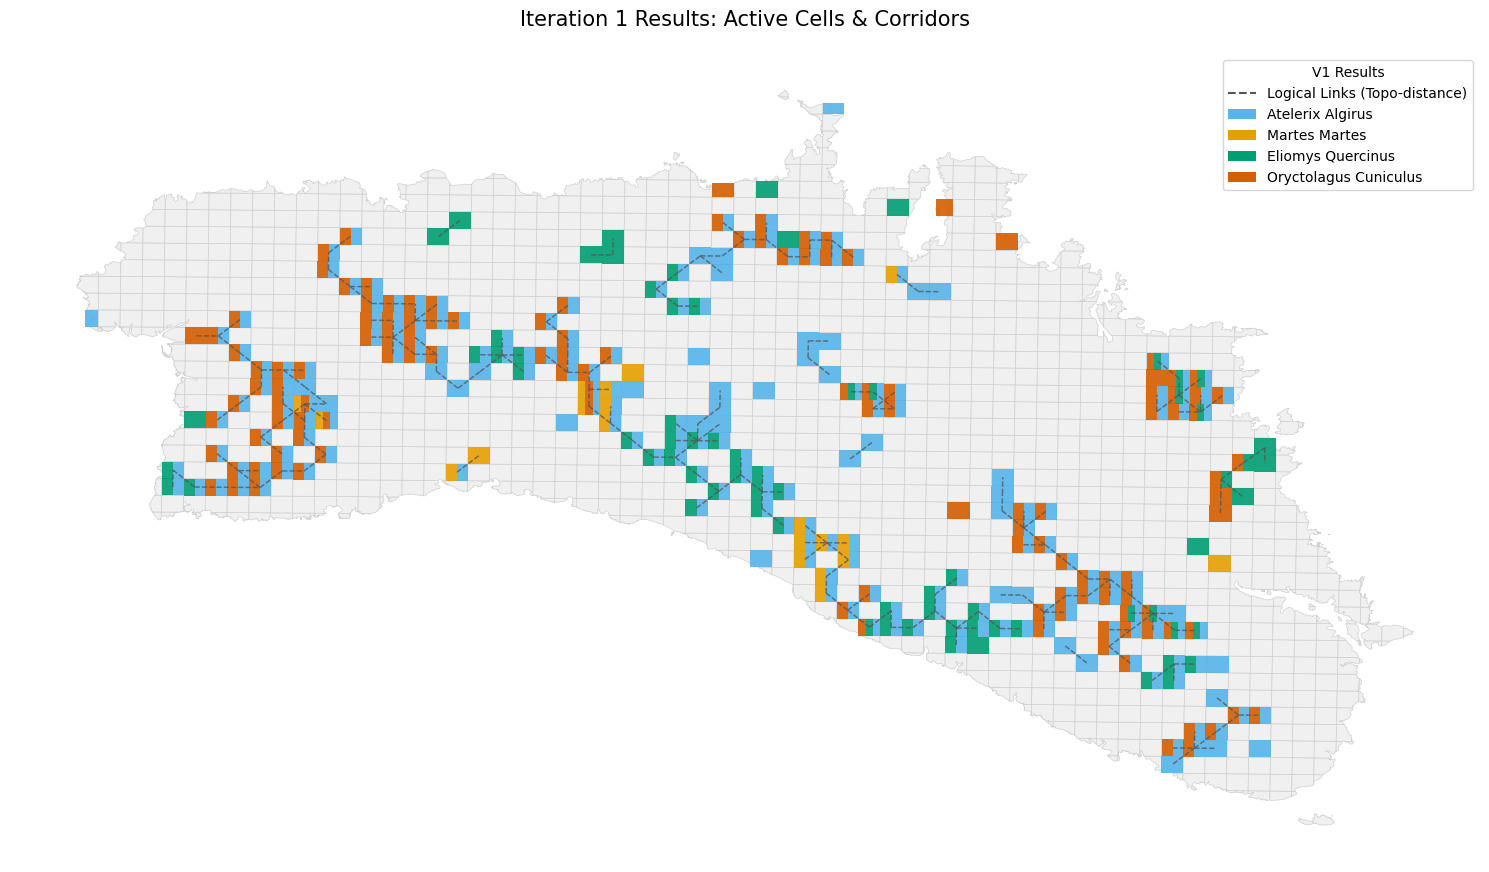

In [6]:
SOLUTION_PATH_V1 = '../../5_results/solutions/solution_v1.csv' 
GEOJSON_PATH = '../../2_data/processed/final_dataset.geojson'
OUTPUT_DIR = '../../5_results/iterations'

gdf = gpd.read_file(GEOJSON_PATH)

df_sol_v1 = pd.read_csv(SOLUTION_PATH_V1)
gdf = gdf.merge(df_sol_v1, on='grid_id', how='left')

SPECIES_COLORS = {
    'martes': '#E69F00',      # Naranja
    'oryctolagus': '#D55E00', # Rojo
    'eliomys': '#009E73',     # Verde
    'atelerix': '#56B4E9'     # Azul
}

fig, ax = plt.subplots(figsize=(15, 12))
ax.set_aspect('equal')
ax.set_title("Iteration 1 Results: Active Cells & Corridors", fontsize=15, pad=20)

gdf.plot(ax=ax, color='#f0f0f0', edgecolor='#d0d0d0', linewidth=0.5)

centroids = {row['grid_id']: (row.geometry.centroid.x, row.geometry.centroid.y) for idx, row in gdf.iterrows()}
corridor_lines = []

if 'corridors' in gdf.columns:
    for idx, row in gdf.iterrows():
        if pd.notna(row['corridors']):
            neighbors = str(row['corridors']).split(';')
            start_pt = centroids.get(row['grid_id'])
            for n_id in neighbors:
                n_id = n_id.strip()
                if n_id in centroids:
                    end_pt = centroids[n_id]
                    corridor_lines.append(LineString([start_pt, end_pt]))

    if corridor_lines:
        gpd.GeoSeries(corridor_lines).plot(ax=ax, color='#555555', linewidth=1.0, alpha=0.5, zorder=2, linestyle='--')

def draw_cell_slices(ax, geom, species_active, colors):
    if not species_active: return
    minx, miny, maxx, maxy = geom.bounds
    width = maxx - minx; height = maxy - miny
    n = len(species_active); slice_w = width / n
    for i, sp in enumerate(species_active):
        rect = Rectangle((minx + i*slice_w, miny), slice_w, height, 
                         facecolor=colors.get(sp, 'grey'), edgecolor='none', alpha=0.9)
        ax.add_patch(rect)

for idx, row in gdf.iterrows():
    active_species = []
    for sp in SPECIES_COLORS.keys():
        col_name = f'active_{sp}' 
        if col_name in row and row[col_name] > 0.5:
            active_species.append(sp)
    
    if active_species:
        draw_cell_slices(ax, row.geometry, active_species, SPECIES_COLORS)

legend_elements = [
    Line2D([0], [0], color='#555555', lw=1.5, linestyle='--', label='Logical Links (Topo-distance)'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['atelerix'], label='Atelerix Algirus'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['martes'], label='Martes Martes'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['eliomys'], label='Eliomys Quercinus'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['oryctolagus'], label='Oryctolagus Cuniculus'),
]

ax.legend(handles=legend_elements, loc='upper right', title="V1 Results")

plt.axis('off')
plt.tight_layout()

out_path = os.path.join(OUTPUT_DIR, 'v1_model_results_map.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
print(f"Map saved: {out_path}")
plt.show()